In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import dynsys_orig as dynsys
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import PRA as pra
from mne_connectivity import spectral_connectivity_epochs
from spectral_connectivity import Multitaper, Connectivity
np.random.seed(42)  # For reproducibility

In [2]:
"""# Lorenz system parameters
sigma = 10
rho = 28
beta = 8 / 3

#Time
seconds = 200
sampling_rate = 100

# Coupling coefficients
c_ij = np.array([[0, .5, .5], [.5, 0, .5], [.5, .5, 0]])
d_ij = np.array([[0, .5, .5], [.5, 0, .5], [.5, .5, 0]])

# External control (assuming it's zero for simplicity)
beta_i = np.array([1, 1, 1])
u_i = lambda t: np.zeros(3)

# The Lorenz equations with linear coupling
def lorenz_coupled(t, state):
    # Unpack the state vector
    x = state[:3]
    y = state[3:6]
    z = state[6:9]

    # Compute the derivatives
    dx_dt = sigma * (y - x) + c_ij @ x
    dy_dt = rho * x - y - x * z + d_ij @ y + beta_i * u_i(t)
    dz_dt = -beta * z + x * y
    
    # Combine the derivatives back into a flat state vector
    return np.concatenate((dx_dt, dy_dt, dz_dt))

# Initial conditions for each of the oscillators
initial_state = np.array([-8.5, 8, 27, -11, 9, 35, -5.5, 1, 10])

# Time span for the integration (in arbitrary time units)
t_span = (0, seconds)
t_eval = np.linspace(*t_span, seconds * sampling_rate)

# Solve the coupled Lorenz system
solution = solve_ivp(lorenz_coupled, t_span, initial_state, t_eval=t_eval, method='RK45')

#Append one extra signal of noise
solution.y = np.vstack((solution.y, np.random.normal(0, 0.1, size=(1, seconds * sampling_rate))))

# Plot the results
plt.figure(figsize=(12, 8))

# Plot x, y, z for each oscillator
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(t_eval, solution.y[i], label=f'x{i+1}')
    #plt.plot(t_eval, solution.y[i+3], label=f'y{i+1}')
    #plt.plot(t_eval, solution.y[i+6], label=f'z{i+1}')
    plt.legend()
plt.tight_layout()
plt.show()
plt.close()


ground_truth_connectivity = np.zeros((10, 10))

# Populate the connectivity for the Lorenz oscillators


# The off-diagonal blocks for the coupling between x and y variables of different oscillators (j to i connectivity)
for i in range(3):
    for j in range(3):
        if i != j:
            ground_truth_connectivity[i*3, j*3] = c_ij[j, i]  # Coupling from xj to xi
            ground_truth_connectivity[i*3+1, j*3+1] = d_ij[j, i]  # Coupling from yj to yi

adjacency_matrix = [[0, 1, 1], [1, 0, 1], [1, 1, 0]]"""

"# Lorenz system parameters\nsigma = 10\nrho = 28\nbeta = 8 / 3\n\n#Time\nseconds = 200\nsampling_rate = 100\n\n# Coupling coefficients\nc_ij = np.array([[0, .5, .5], [.5, 0, .5], [.5, .5, 0]])\nd_ij = np.array([[0, .5, .5], [.5, 0, .5], [.5, .5, 0]])\n\n# External control (assuming it's zero for simplicity)\nbeta_i = np.array([1, 1, 1])\nu_i = lambda t: np.zeros(3)\n\n# The Lorenz equations with linear coupling\ndef lorenz_coupled(t, state):\n    # Unpack the state vector\n    x = state[:3]\n    y = state[3:6]\n    z = state[6:9]\n\n    # Compute the derivatives\n    dx_dt = sigma * (y - x) + c_ij @ x\n    dy_dt = rho * x - y - x * z + d_ij @ y + beta_i * u_i(t)\n    dz_dt = -beta * z + x * y\n    \n    # Combine the derivatives back into a flat state vector\n    return np.concatenate((dx_dt, dy_dt, dz_dt))\n\n# Initial conditions for each of the oscillators\ninitial_state = np.array([-8.5, 8, 27, -11, 9, 35, -5.5, 1, 10])\n\n# Time span for the integration (in arbitrary time units)\n

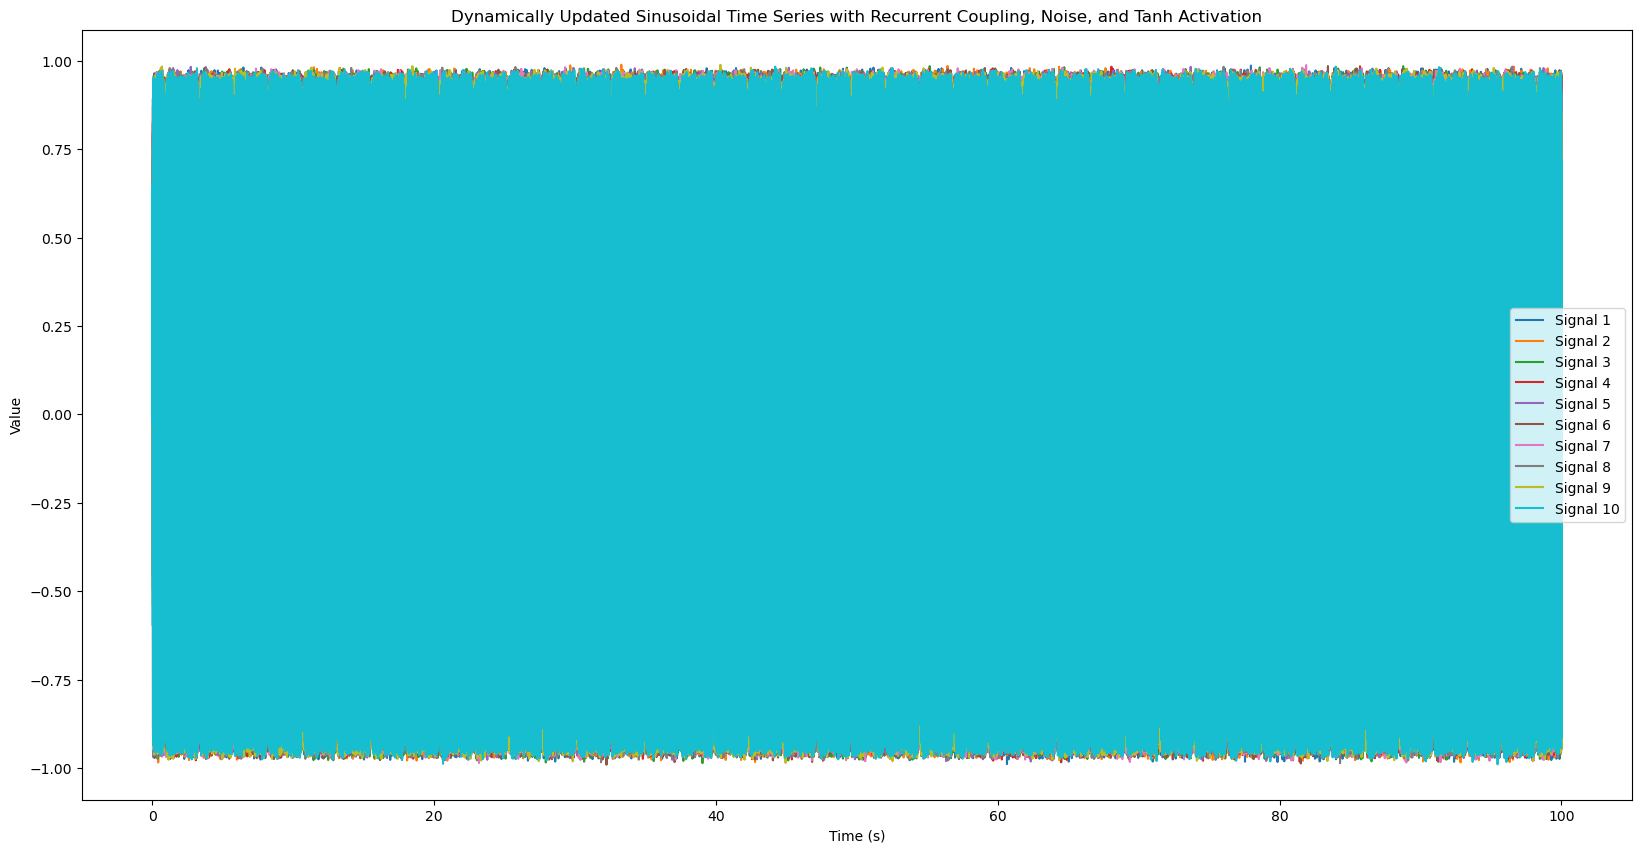

Adjacency Matrix:
[[0 0 0 0 0 0 0 0 1 1]
 [1 0 0 0 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 1 1 0]]


In [3]:

# Parameters
sampling_rate = 100  # Hz
duration = 100 # seconds
n_points = sampling_rate * duration
time = np.linspace(0, duration, n_points)

# Generate 10 base sine waves with distinct frequencies
frequencies = np.linspace(8.7, 12.4, 10)  # From 8.7 Hz to 12.4 Hz in 10 steps
signals = np.sin(2 * np.pi * np.outer(frequencies, time))



# Coupling parameters
coupling_strength = 1.0  # Uniform coupling strength
lag = 2  # Uniform lag
noise_level = 0.01  # Noise level

# Adjacency matrix initialization
adjacency_matrix = np.zeros((10, 10), dtype=int)

# Define coupling connections and apply dynamic updating with tanh activation
for i in range(10):
    influenced_signals = [(i + 1) % 10, (i + 2) % 10]  # Signals influenced by signal i
    for j in influenced_signals:
        adjacency_matrix[j, i] = 1  # Update adjacency matrix

# Dynamic updating with coupling and tanh activation
for t in range(lag, n_points):
    for i in range(10):
        influenced_signals = [(i + 1) % 10, (i + 2) % 10]  # Signals influenced by signal i
        for j in influenced_signals:
            signals[j, t] -= coupling_strength * signals[i, t - lag]
            # Apply non linear activation to limit the signal values and model neural dynamics
            signals[j, t] = np.tanh(signals[j, t])

# Add noise after dynamic updating
signals += noise_level * np.random.randn(*signals.shape)

# Plotting the signals
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.plot(time, signals[i], label=f'Signal {i+1}')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.title('Dynamically Updated Sinusoidal Time Series with Recurrent Coupling, Noise, and Tanh Activation')
plt.show()

# Display the adjacency matrix
print("Adjacency Matrix:")
print(adjacency_matrix)


In [4]:
"""# Parameters
sampling_rate = 100  # Hz
duration = 200  # seconds
n_points = sampling_rate * duration
time = np.linspace(0, duration, n_points)

# Generate mixed base signals
frequencies = np.linspace(5, 15, 10)  # Different frequency range
amplitudes = np.linspace(0.5, 1.5, 10)  # Varying amplitudes
signals = np.zeros((10, n_points))
for i, (freq, amp) in enumerate(zip(frequencies, amplitudes)):
    if i % 2 == 0:
        signals[i] = amp * np.sin(2 * np.pi * freq * time)
    else:
        signals[i] = amp * np.cos(2 * np.pi * freq * time)

# Coupling parameters
coupling_strength = 1.0  # Uniform coupling strength
lag = 2  # Uniform lag set to 1
noise_level = 0.1  # Noise level

# Adjacency matrix initialization
adjacency_matrix = np.zeros((10, 10), dtype=int)

# Define new coupling connections using a prime number based pattern
primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]  # Prime numbers for variability
for i in range(10):
    # Select three unique influenced signals for each signal based on prime steps
    influenced_signals = [(i + prime) % 10 for prime in primes[:3]]  # First three primes for simplicity
    for j in influenced_signals:
        adjacency_matrix[j, i] = 1  # Note the correction: i influences j

# Dynamic updating with coupling and tanh activation
for t in range(lag, n_points):
    for i in range(10):
        for j in range(10):
            if adjacency_matrix[i, j] == 1:
                signals[j, t] += coupling_strength * signals[i, t - lag]
                # Apply tanh activation to limit the signal values
                signals[j, t] = np.tanh(signals[j, t])

# Add noise after dynamic updating
signals += noise_level * np.random.randn(*signals.shape)

# Plotting the signals
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.plot(time, signals[i], label=f'Signal {i+1}')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.title('Diverse Sinusoidal Time Series with Modified Connectivity, Noise, and Tanh Activation')
plt.show()

print("Adjacency Matrix:")
print(adjacency_matrix)"""


'# Parameters\nsampling_rate = 100  # Hz\nduration = 200  # seconds\nn_points = sampling_rate * duration\ntime = np.linspace(0, duration, n_points)\n\n# Generate mixed base signals\nfrequencies = np.linspace(5, 15, 10)  # Different frequency range\namplitudes = np.linspace(0.5, 1.5, 10)  # Varying amplitudes\nsignals = np.zeros((10, n_points))\nfor i, (freq, amp) in enumerate(zip(frequencies, amplitudes)):\n    if i % 2 == 0:\n        signals[i] = amp * np.sin(2 * np.pi * freq * time)\n    else:\n        signals[i] = amp * np.cos(2 * np.pi * freq * time)\n\n# Coupling parameters\ncoupling_strength = 1.0  # Uniform coupling strength\nlag = 2  # Uniform lag set to 1\nnoise_level = 0.1  # Noise level\n\n# Adjacency matrix initialization\nadjacency_matrix = np.zeros((10, 10), dtype=int)\n\n# Define new coupling connections using a prime number based pattern\nprimes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]  # Prime numbers for variability\nfor i in range(10):\n    # Select three unique influe

In [5]:
## simulated data
#sim_data = np.array([A,B,C])
ch_names=["A", "B", "C","D","E","F","G","H","I","J"]
#ch_names = ["A", "B", "C"]
#sim_data = np.array([solution.y[1], solution.y[4], solution.y[7]])
sim_data = np.array(signals)
#sim_data = np.array(solution.y[:10])
info = mne.create_info(ch_names=ch_names, ch_types=["eeg"]*10, sfreq=sampling_rate)
simulated_raw = mne.io.RawArray(sim_data, info)
epochs = mne.make_fixed_length_epochs(simulated_raw, duration=20.0)

Creating RawArray with float64 data, n_channels=10, n_times=25000
    Range : 0 ... 24999 =      0.000 ...    99.996 secs
Ready.
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated


In [6]:
## estimations
#dynsys
epoch_idx = np.arange(1)
region = ['A','B','C']
#dynsys_mat,cond_num,mse,snr = dynsys.dynSys(epochs.get_data(), epoch_idx, region, sampling_time=(1/sampling_rate))

#PRA
pra_mat = pra.PRA(epochs.get_data(),sampling_frequency=sampling_rate,num_reservoir=25)


#coh 
mne_con = spectral_connectivity_epochs(epochs, method='coh', sfreq=sampling_rate, fskip=0, faverage=False,
                                      mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)
coh_mat = mne_con.get_data(output="dense")

#ciplv
mne_con = spectral_connectivity_epochs(epochs, method='ciplv', sfreq=sampling_rate, fskip=0, faverage=False,
                                      mt_low_bias=True, block_size=1000, n_jobs=1, verbose=None)
ciplv_mat = mne_con.get_data(output="dense")

#gpdc
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=sampling_rate)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'generalized_partial_directed_coherence')()
gpdc_mat = np.nan_to_num(con.squeeze()).transpose(1,2,0)

#ddtf
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=sampling_rate)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'direct_directed_transfer_function')()
ddtf_mat = np.nan_to_num(con.squeeze()).transpose(1,2,0)

#psgp
m = Multitaper(time_series=np.array(epochs.get_data()).transpose(2, 0, 1), sampling_frequency=sampling_rate)
c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
con = getattr(c, 'pairwise_spectral_granger_prediction')()
psgp_mat = np.nan_to_num(con.squeeze()).transpose(1,2,0)

Using data from preloaded Raw for 5 events and 5000 original time points ...
0 bad epochs dropped


  0%|          | 0/5 [00:00<?, ?it/s]

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 45 connections
    using t=0.000s..19.996s for estimation (5000 points)
    frequencies: 0.2Hz..125.0Hz (2496 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    assembling connectivity matrix
[Connectivity computation done]
Replacing existing metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 45 connections
    using t=0.000s..19.996s for estimation (5000 points)
    frequencies: 0.2Hz..125.0Hz (2496 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be comput

Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged
Maximum iterations reached. 0 of 1 converged


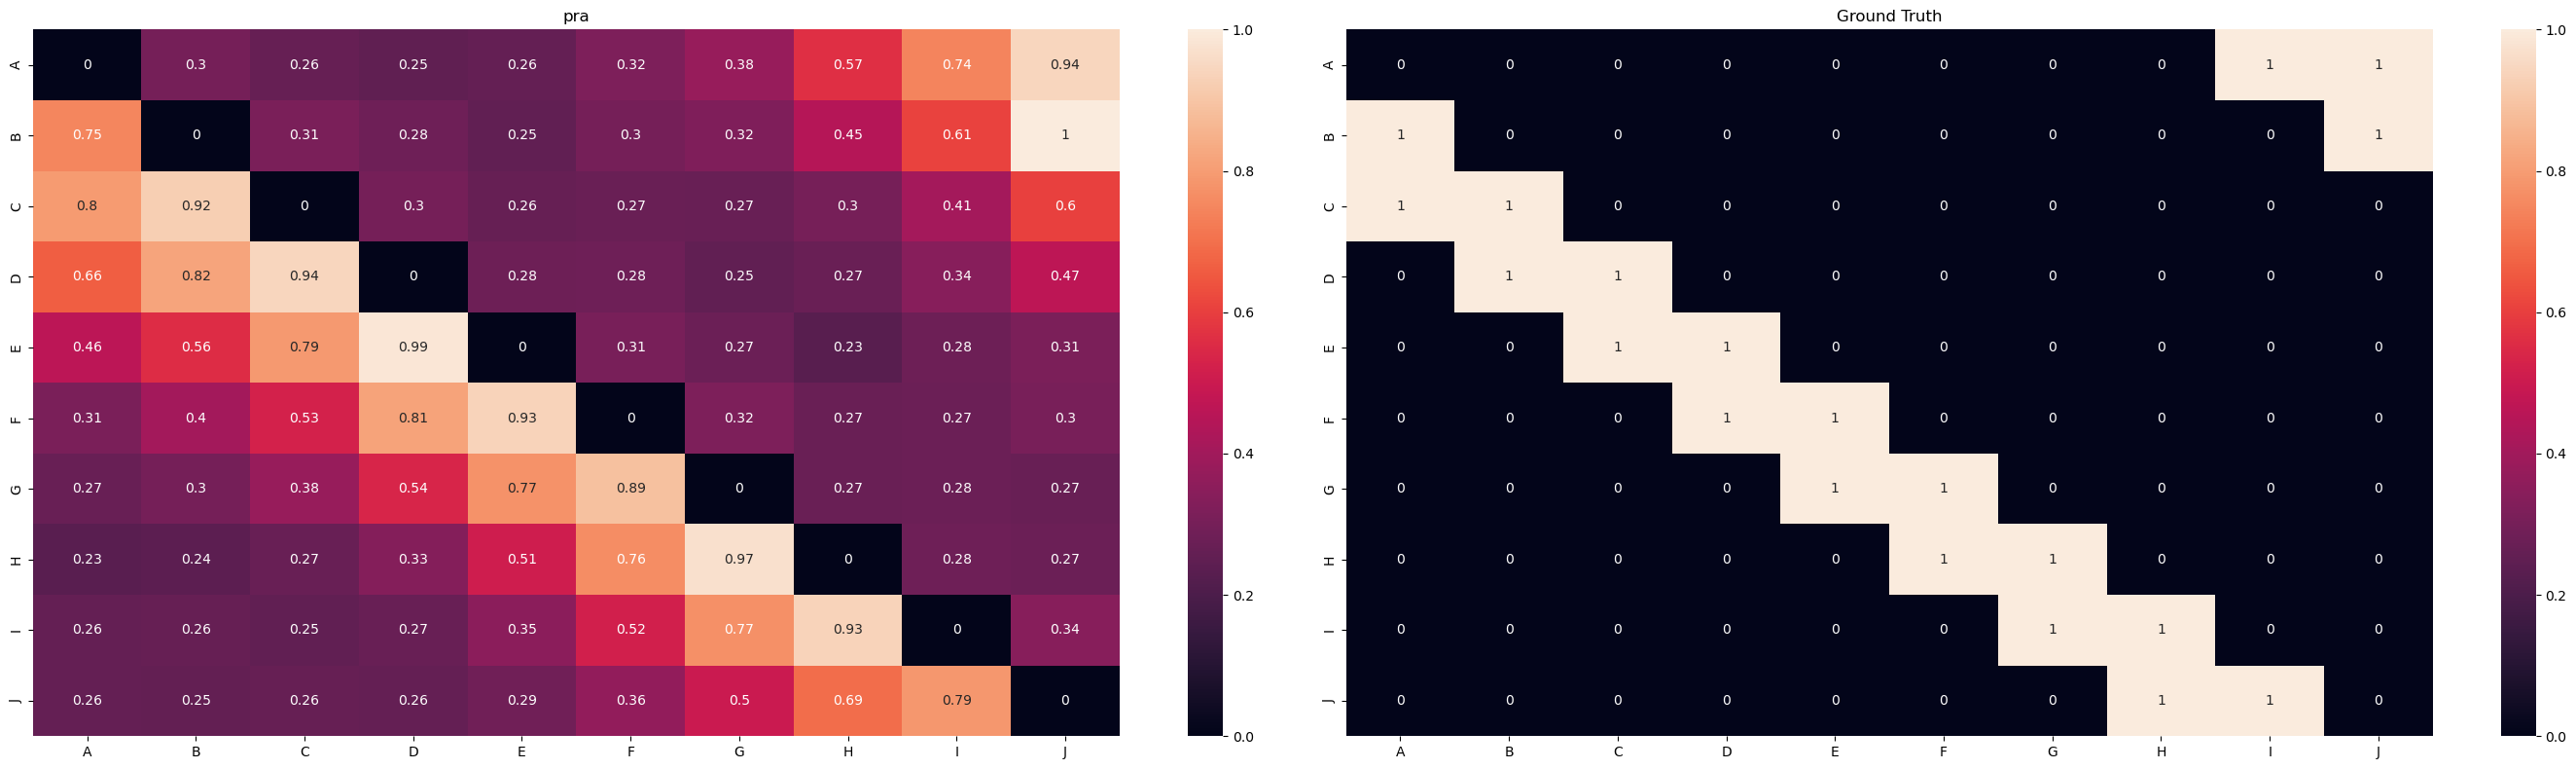

In [7]:

labels = ['A','B','C','D','E','F','G','H','I','J']

fig, (ax2,ax3) = plt.subplots(1,2,figsize=(28,8))
#sns.heatmap(dynsys_mat.squeeze(), annot=True, xticklabels=ch_names, yticklabels=ch_names, ax=ax1)
#ax1.set_title('dynsys')

sns.heatmap(pra_mat, annot=True, xticklabels=ch_names, yticklabels=ch_names, ax=ax2)
ax2.set_title('pra')

# Plotting the ground truth connectivity matrix
#plt.figure(figsize=(10, 8))
sns.heatmap(adjacency_matrix, annot=True, xticklabels=ch_names, yticklabels=ch_names, ax=ax3)
ax3.set_title('Ground Truth')

fig.tight_layout()
plt.show()


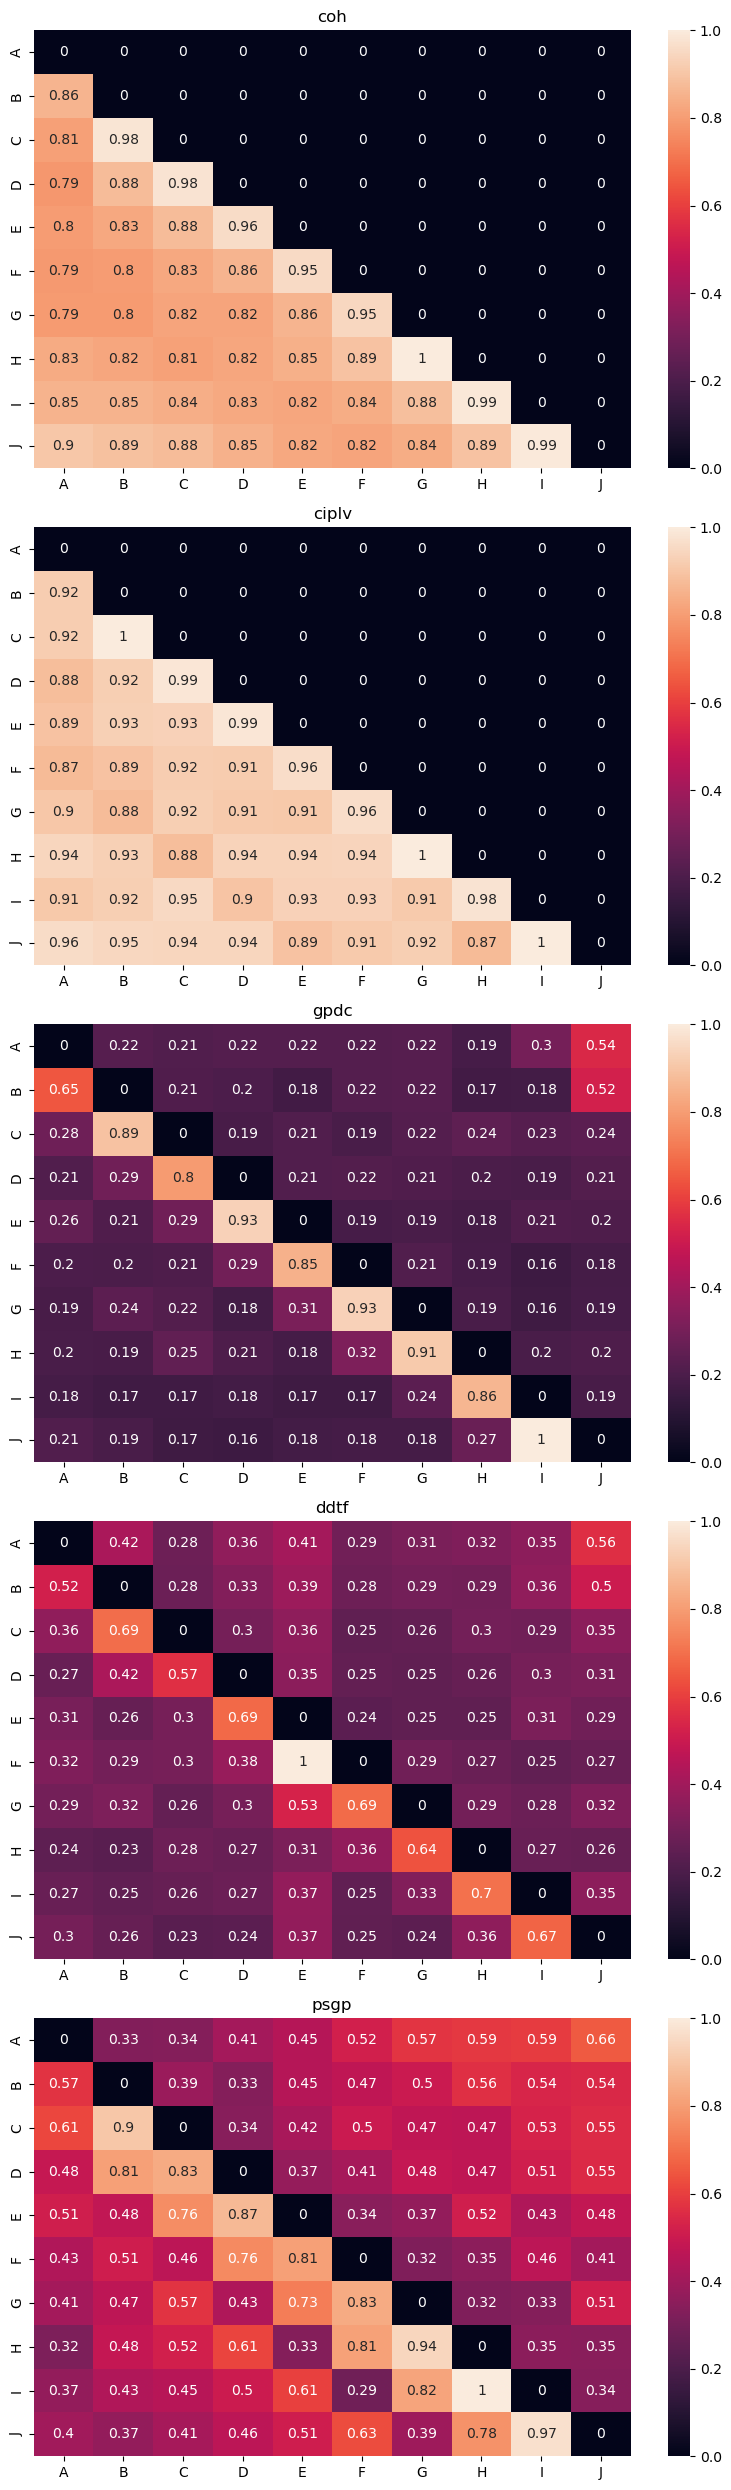

In [8]:
#Zero out the diagonal of each matrix, then min max normalize it
coh_mat = coh_mat.mean(2)
ciplv_mat = ciplv_mat.mean(2)
gpdc_mat = gpdc_mat.mean(2)
ddtf_mat = ddtf_mat.mean(2)
psgp_mat = psgp_mat.mean(2)
np.fill_diagonal(coh_mat,0)
np.fill_diagonal(ciplv_mat,0)
np.fill_diagonal(gpdc_mat,0)
np.fill_diagonal(ddtf_mat,0)
np.fill_diagonal(psgp_mat,0)

coh_mat = (coh_mat - np.min(coh_mat)) / (np.max(coh_mat) - np.min(coh_mat))
ciplv_mat = (ciplv_mat - np.min(ciplv_mat)) / (np.max(ciplv_mat) - np.min(ciplv_mat))
gpdc_mat = (gpdc_mat - np.min(gpdc_mat)) / (np.max(gpdc_mat) - np.min(gpdc_mat))
ddtf_mat = (ddtf_mat - np.min(ddtf_mat)) / (np.max(ddtf_mat) - np.min(ddtf_mat))
psgp_mat = (psgp_mat - np.min(psgp_mat)) / (np.max(psgp_mat) - np.min(psgp_mat))


fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(8,25))
sns.heatmap(coh_mat, annot=True, xticklabels=ch_names, yticklabels=ch_names, ax=ax1)
ax1.set_title('coh')

sns.heatmap(ciplv_mat, annot=True, xticklabels=ch_names, yticklabels=ch_names, ax=ax2)
ax2.set_title('ciplv')

sns.heatmap(gpdc_mat, annot=True, xticklabels=ch_names, yticklabels=ch_names, ax=ax3)
ax3.set_title('gpdc')

sns.heatmap(ddtf_mat, annot=True, xticklabels=ch_names, yticklabels=ch_names, ax=ax4)
ax4.set_title('ddtf')

sns.heatmap(psgp_mat, annot=True, xticklabels=ch_names, yticklabels=ch_names, ax=ax5)
ax5.set_title('psgp')
fig.tight_layout()
plt.show()

In [9]:
#Get lower triangular version of adjacency matrix with symmetric values
adjacency_matrix_lower = np.tril(np.maximum(adjacency_matrix,adjacency_matrix.T), k=-1)
coh_mat = np.tril(coh_mat, k=-1)
ciplv_mat = np.tril(ciplv_mat, k=-1)

#Calculating the MSE between the estimated and ground truth connectivity matrices
#mse_dynsys = np.mean((dynsys_mat.squeeze() - adjacency_matrix) ** 2)
mse_pra = np.mean((pra_mat - adjacency_matrix) ** 2)
mse_coh = np.mean((coh_mat - adjacency_matrix_lower) ** 2)
mse_ciplv = np.mean((ciplv_mat - adjacency_matrix_lower) ** 2)
mse_gpdc = np.mean((gpdc_mat - adjacency_matrix) ** 2)
mse_ddtf = np.mean((ddtf_mat - adjacency_matrix) ** 2)
mse_psgp = np.mean((psgp_mat - adjacency_matrix) ** 2)
#print(f'MSE dynsys: {mse_dynsys}')
print(f'MSE pra: {mse_pra}')
print(f'MSE coh: {mse_coh}')
print(f'MSE ciplv: {mse_ciplv}')
print(f'MSE gpdc: {mse_gpdc}')
print(f'MSE ddtf: {mse_ddtf}')
print(f'MSE psgp: {mse_psgp}')


MSE pra: 0.09292496305679016
MSE coh: 0.1718114489470867
MSE ciplv: 0.2102849861129271
MSE gpdc: 0.08064335594879914
MSE ddtf: 0.11106560549421614
MSE psgp: 0.15723106799654643
